In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Path to dataset files:", path)

100%|██████████| 98.7M/98.7M [00:00<00:00, 173MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1


**Data processing**

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory


In [5]:
import os

# Define the base dataset path
dataset_path = "/root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1"

# Walk through the dataset directory
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print("-" * 40)


Root: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1
Dirs: ['melanoma_cancer_dataset']
----------------------------------------
Root: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset
Dirs: ['train', 'test']
----------------------------------------
Root: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset/train
Dirs: ['malignant', 'benign']
----------------------------------------
Root: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset/train/malignant
Dirs: []
----------------------------------------
Root: /root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset/train/benign
Dirs: []
----------------------------------------
Root: /root/.cache/kagg

# **Data Preprocessing**

In [6]:
dataset_path = "/root/.cache/kagglehub/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/versions/1/melanoma_cancer_dataset"
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')


In [7]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

# Load training dataset
train_dataset = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class labels
    batch_size=32,
    image_size=(224, 224),  # Resize images
    shuffle=True,
    validation_split=0.2,  # 20% of training data for validation
    subset="training",
    seed=123
)

# Load validation dataset
val_dataset = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123
)

# Load testing dataset
test_dataset = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False
)


Found 9605 files belonging to 2 classes.
Using 7684 files for training.
Found 9605 files belonging to 2 classes.
Using 1921 files for validation.
Found 1000 files belonging to 2 classes.


# **Data Augmentation**

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness

# Define the augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),    # Flip images horizontally and vertically
    RandomRotation(0.2),                      # Rotate images randomly by 20% (0.2 radians)
    RandomZoom(height_factor=(-0.2, 0.2)),    # Zoom images randomly
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2))  # Adjust brightness
])


In [9]:
def augment_data(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Apply augmentation only to the training dataset
train_augmented_dataset = augment_data(train_dataset)

# Validation and test datasets should remain unchanged
val_dataset = val_dataset
test_dataset = test_dataset


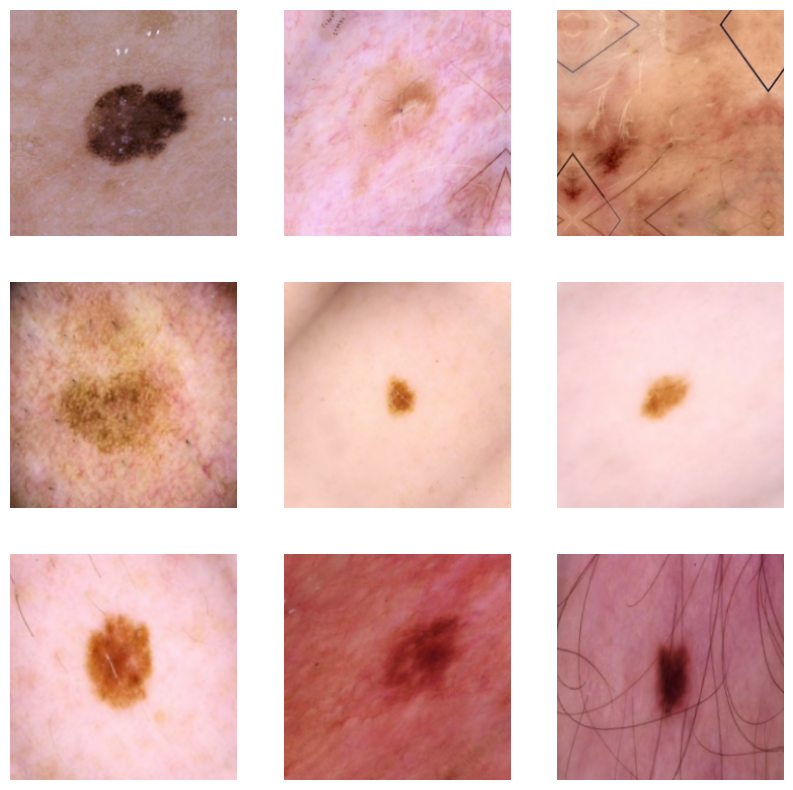

In [10]:
import matplotlib.pyplot as plt

# Display a batch of augmented images
for images, labels in train_augmented_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    break


Model Development:
### Using a pre-trained CNN model

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam


# **Using ResNet50**

In [12]:
# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model so that its weights are not updated during training
base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Creating Our Custom Model**

In [13]:
# Create the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling the output from base model
    layers.Dense(1024, activation='relu'),  # Add a fully connected layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use Adam optimizer
    loss='binary_crossentropy',  # Binary Crossentropy for binary classification
    metrics=['accuracy']
)


# **Fine Tuning the Model**

In [14]:
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 10 layers of the base model
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile the model after unfreezing layers
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# **Model Training**

In [15]:
# Modify the output layer to have 2 units (for two classes)
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model with categorical crossentropy
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Change to categorical crossentropy
    metrics=['accuracy']
)


In [16]:
# Check the labels to ensure they are one-hot encoded
for images, labels in train_dataset.take(1):
    print("Labels:", labels)


Labels: tf.Tensor(
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(32, 2), dtype=float32)


In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-learned features
base_model.trainable = False

# Create a new model with the pre-trained base model and custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pool the output from the base model
    layers.Dense(1024, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(2, activation='softmax')  # Output layer with 2 units for multi-class classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_augmented_dataset,  # Augmented training data
    validation_data=val_dataset,  # Validation data
    epochs=10,
    steps_per_epoch=len(train_augmented_dataset),
    validation_steps=len(val_dataset)
)


Epoch 1/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8021 - loss: 0.4337